Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [44]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Rescaling

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from glob import glob

import Augmentor

import warnings
warnings.filterwarnings("ignore")

# Data Reading/Data Understanding

Defining the path for train and test images

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [45]:
# Importing Skin Cancer Data
# Defining the path for train and test images
curr_dir_path = pathlib.Path.cwd()
print("Current Working Directory:", curr_dir_path)

base_path = pathlib.Path(curr_dir_path)
ds_subdir = "Skin cancer ISIC The International Skin Imaging Collaboration"
path_to_training_dataset = base_path / ds_subdir / "Train"
path_to_testing_dataset = base_path / ds_subdir / "Test"

print("Training Dataset path:", path_to_training_dataset)
print("Testing Dataset path:", path_to_testing_dataset)

data_dir_train = pathlib.Path(path_to_training_dataset)
data_dir_test = pathlib.Path(path_to_testing_dataset)

Current Working Directory: /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment
Training Dataset path: /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train
Testing Dataset path: /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test


In [46]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [47]:
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118


In [48]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [49]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 20239 files belonging to 9 classes.
Using 16192 files for training.


In [50]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 20239 files belonging to 9 classes.
Using 4047 files for validation.


In [51]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [52]:
# Listing out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Dataset visualisation

Creating a code to visualize one instance of all the nine classes present in the dataset

In [53]:
def plot_image(filenames, title=None):
    image = plt.imread(filenames)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")

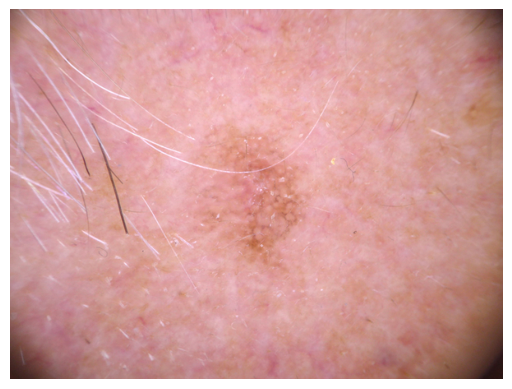

In [54]:
img_set = (list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0])
plot_image(img_set)

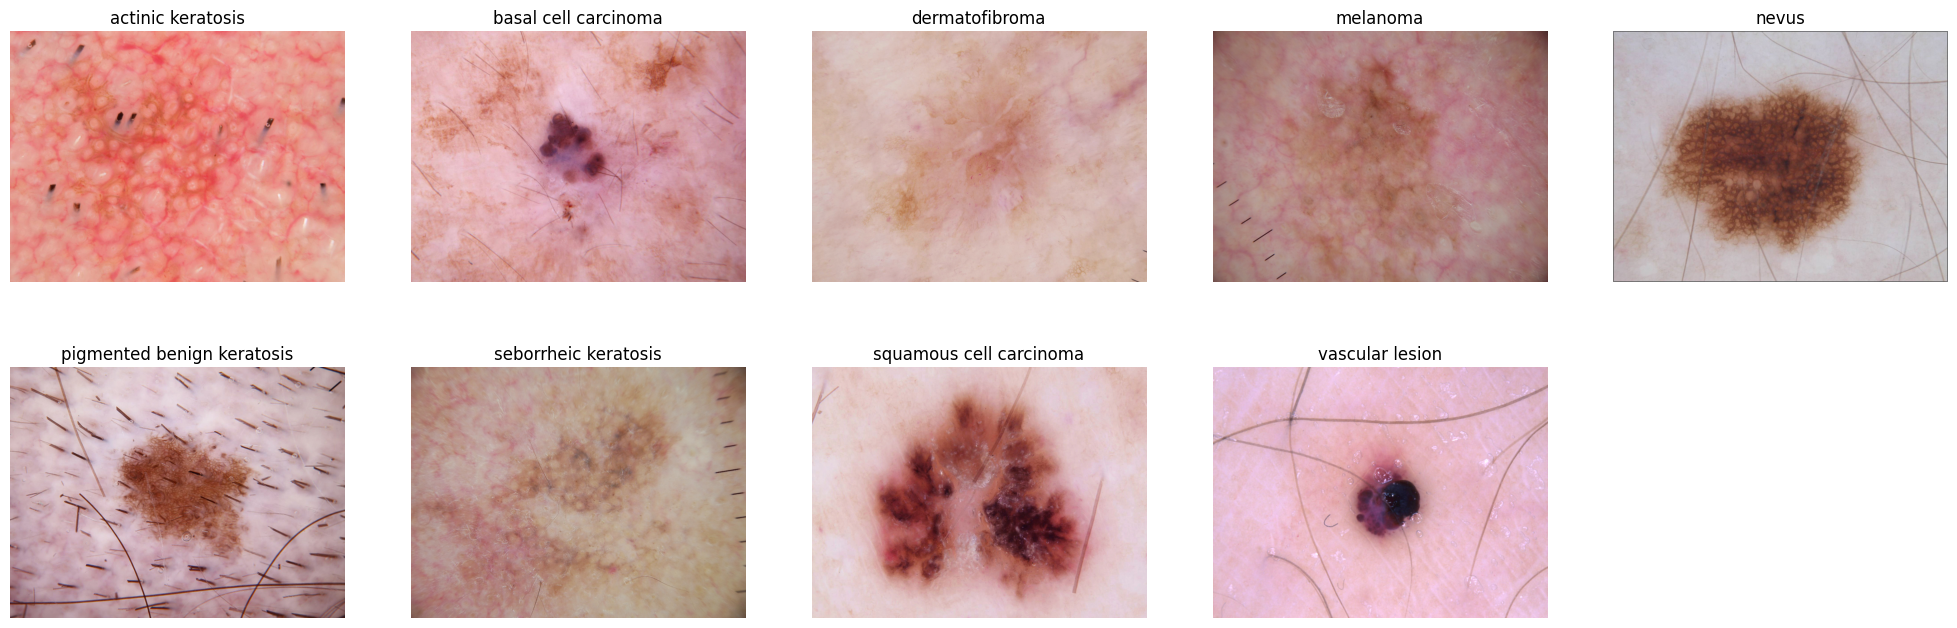

In [55]:
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  img_name = str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1])
  plot_image(img_name, title=class_names[i])

### Visualize distribution of classes in the training dataset.**

In [56]:
def class_distribution_count(directory):
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

In [57]:
df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,pigmented benign keratosis,462
2,nevus,357
3,basal cell carcinoma,376
4,actinic keratosis,114
5,squamous cell carcinoma,181
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95


<Axes: xlabel='No. of Image', ylabel='Class'>

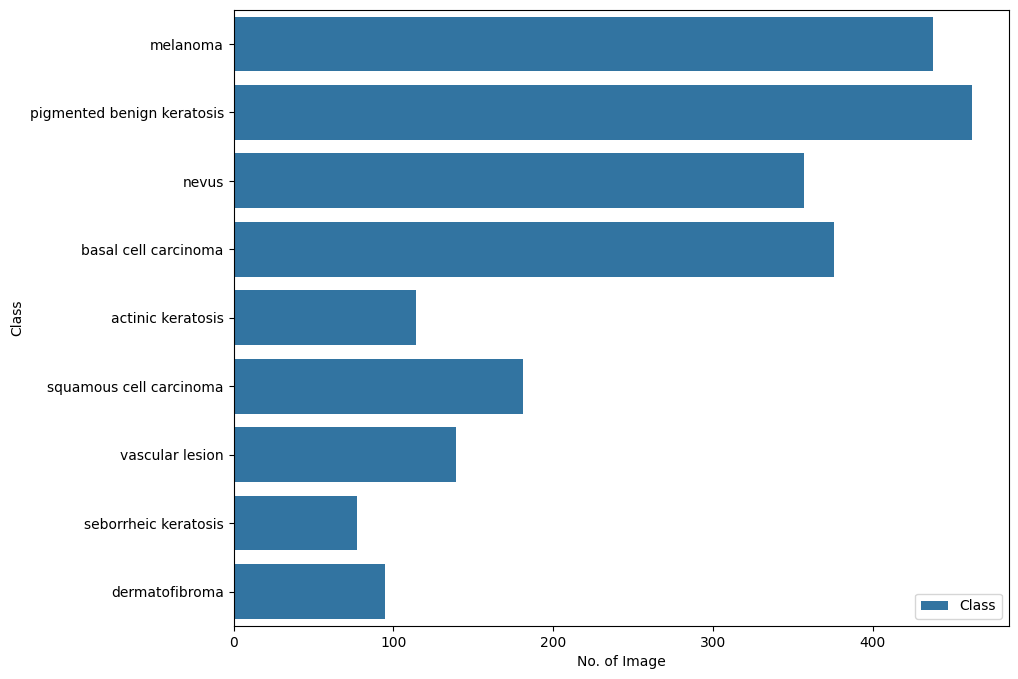

In [58]:
#Visualize the Number of image in each class.
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df, label="Class")

## Handling Class imbalance

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [59]:
for i in class_names:
    source_dir = os.path.join(curr_dir_path, ds_subdir, path_to_training_dataset.name, i)
    print("Source Directory : ", source_dir)
    
    p = Augmentor.Pipeline(source_dir)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3279E9850>: 100%|██████████| 500/500 [00:00<00:00, 731.20 Samples/s]                  


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3351D9BE0>: 100%|██████████| 500/500 [00:00<00:00, 786.63 Samples/s]


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x335A88E60>: 100%|██████████| 500/500 [00:00<00:00, 747.86 Samples/s]


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x335A8A6C0>: 100%|██████████| 500/500 [00:03<00:00, 165.73 Samples/s]                  


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x335171820>: 100%|██████████| 500/500 [00:02<00:00, 179.79 Samples/s]                    


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x335A506E0>: 100%|██████████| 500/500 [00:00<00:00, 679.85 Samples/s]                  


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x335A460C0>: 100%|██████████| 500/500 [00:01<00:00, 342.32 Samples/s]


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x335170350>: 100%|██████████| 500/500 [00:00<00:00, 697.29 Samples/s]


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x335B334A0>: 100%|██████████| 500/500 [00:00<00:00, 686.86 Samples/s]                  


In [60]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

22500


# Model Building & training : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [61]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 24739 files belonging to 9 classes.
Using 19792 files for training.


In [62]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 24739 files belonging to 9 classes.
Using 4947 files for validation.


In [63]:
# Configure the dataset for performance

#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [64]:
def create_cnn_model(data_augmentation=None):
    #Sequential allows you to create models layer-by-layer
    model=models.Sequential()

    # Rescaling Layer. scaling the pixel values from 0-255 to 0-1
    model.add(Rescaling(1./255,input_shape=(180,180,3)))

    # adding the augmentation layer before the convolution layer
    if data_augmentation:
        model.add(data_augmentation)

    #First Convulation layer
    model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Second Convulation Layer
    model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Third Convulation Layer
    model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Dropout layer with 50% Fraction of the input units to drop.
    model.add(layers.Dropout(0.5))

    #Flatten Layer
    ##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
    model.add(layers.Flatten())

    #Dense Layer
    model.add(layers.Dense(128,activation='relu'))

    #Dropout layer with 25% Fraction of the input units to drop.
    model.add(layers.Dropout(0.25))

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    model.add(layers.Dense(len(class_names),activation='softmax'))

    model.summary()
    return model

In [65]:
def compile_model(model):
    model.summary()
    #Compile the Model

    #Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
    #categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

    model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

    #ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
    #so the model or weights can be loaded later to continue the training from the state saved.
    checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

    #Stop training when a monitored metric has stopped improving.
    earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
    return checkpoint, earlystop

In [66]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [67]:
model = create_cnn_model()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# vizualizing the model 
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [69]:
checkpoint, earlystop = compile_model(model)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
def train_model_with_epoch(epochs, train_ds, val_ds, callbacks):
    return model.fit(train_ds,validation_data=val_ds,epochs=epochs, callbacks=callbacks)

In [71]:
# Training the model
epochs = 20
history = train_model_with_epoch(epochs, train_ds, val_ds, callbacks=[checkpoint,earlystop])

Epoch 1/20
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.2773 - loss: 1.8616
Epoch 1: val_accuracy improved from -inf to 0.52133, saving model to model.keras
619/619 ━━━━━━━━━━━━━━━━━━━━ 118s 179ms/step - accuracy: 0.2775 - loss: 1.8612 - val_accuracy: 0.5213 - val_loss: 1.2650
Epoch 2/20
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5179 - loss: 1.2763
Epoch 2: val_accuracy improved from 0.52133 to 0.61027, saving model to model.keras
619/619 ━━━━━━━━━━━━━━━━━━━━ 119s 193ms/step - accuracy: 0.5179 - loss: 1.2761 - val_accuracy: 0.6103 - val_loss: 1.0515
Epoch 3/20
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6232 - loss: 1.0140
Epoch 3: val_accuracy improved from 0.61027 to 0.69618, saving model to model.keras
619/619 ━━━━━━━━━━━━━━━━━━━━ 107s 173ms/step - accuracy: 0.6233 - loss: 1.0139 - val_accuracy: 0.6962 - val_loss: 0.8396
Epoch 4/20
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6897 - loss: 0.8190
Epoch 4: val_accuracy improved from 

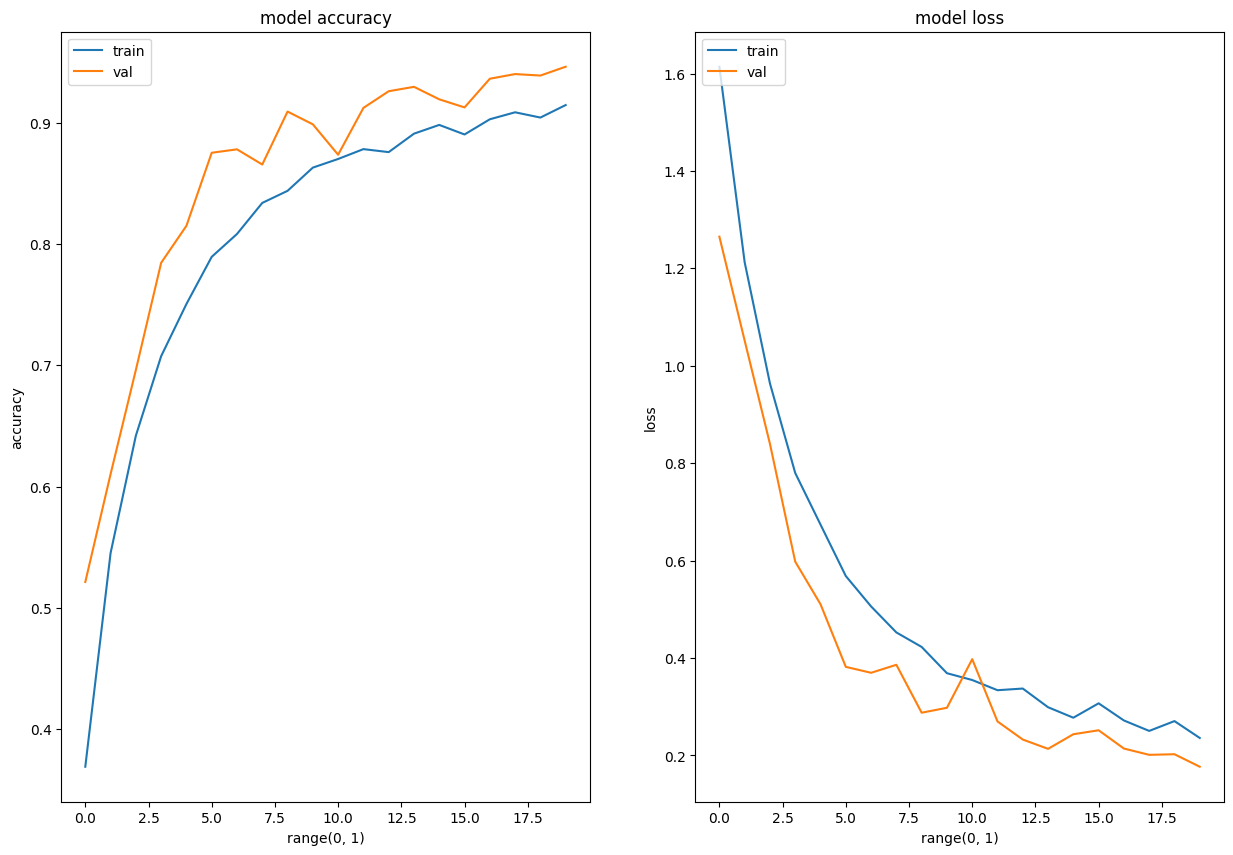

In [72]:
# Plot the training curves
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

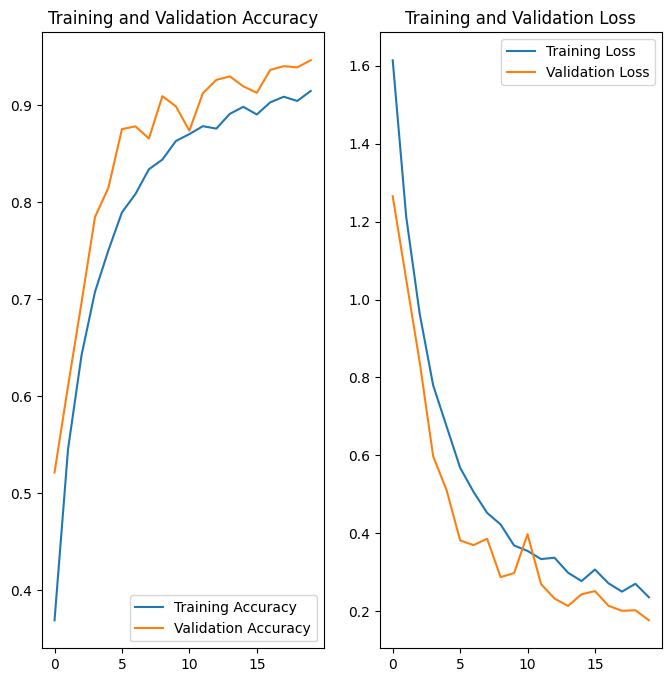

In [73]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

<b>Observations:</b>
<ol>        
<li>The model's training accuracy displays a linear increase over time, whereas the validation accuracy plateaus at 50% accuracy during the training process.
<li>As the training epochs progress, the training loss decreases, however, the validation loss exhibits an opposing trend and increases.
<li>The visual representation of the model's performance indicates a substantial discrepancy between the training accuracy and validation accuracy, achieving a validation accuracy of approximately 50%.
<li>The noticeable difference between the training accuracy and validation accuracy is a clear indication of overfitting, indicating that the model may not generalize well to unseen data.
</ol>

## Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


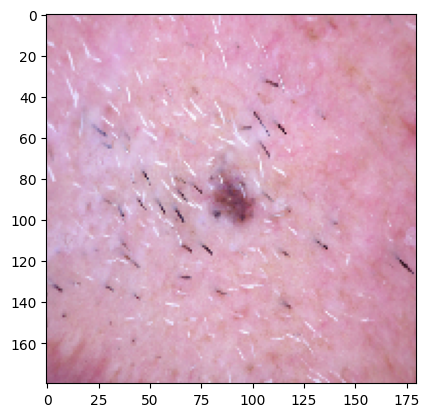

In [74]:
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )